### Imports & Logging Setup

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Dataset

In [6]:
# Load the miRNA dataset
file_path = "../processed_data/miRNA_stage_subtype.csv"  # Adjust path if needed
miRNA_df = pd.read_csv(file_path)

# Check dataset structure
print("Dataset Shape:", miRNA_df.shape)
print("Columns:", miRNA_df.columns)

# Create a binary diagnosis column (0 = Healthy, 1 = Cancer)
miRNA_df["diagnosis"] = miRNA_df["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Verify if the column was created
print("Updated Dataset Columns:\n", miRNA_df.columns)


Dataset Shape: (1091, 1883)
Columns: Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-943', 'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500',
       'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a', 'hsa-mir-99b', 'stage',
       'subtype'],
      dtype='object', length=1883)
Updated Dataset Columns:
 Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98',
       'hsa-mir-99a', 'hsa-mir-99b', 'stage', 'subtype', 'diagnosis'],
      dtype='object', length=1884)


### Feature Selection & Labels

In [7]:
# Extract features (all miRNA expression values)
X = miRNA_df.iloc[:, :-3]  # Exclude the last three columns (diagnosis, stage, subtype)

# Extract labels for classification tasks
y_diagnosis = miRNA_df["diagnosis"]
y_stage = miRNA_df["stage"]
y_subtype = miRNA_df["subtype"]

print("Feature Matrix Shape:", X.shape)
print("Diagnosis Labels Distribution:\n", y_diagnosis.value_counts(normalize=True))
print("Stage Labels Distribution:\n", y_stage.value_counts(normalize=True))
print("Subtype Labels Distribution:\n", y_subtype.value_counts(normalize=True))

Feature Matrix Shape: (1091, 1881)
Diagnosis Labels Distribution:
 diagnosis
1    0.989918
0    0.010082
Name: proportion, dtype: float64
Stage Labels Distribution:
 stage
1    0.518790
2    0.282310
3    0.160403
4    0.028414
0    0.010082
Name: proportion, dtype: float64
Subtype Labels Distribution:
 subtype
1    0.513291
2    0.475710
0    0.010082
4    0.000917
Name: proportion, dtype: float64


### Code (Feature Scaling & Train-Test Split)

In [11]:
# Standardize features for consistency with SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fix: Merge rare subtype (Subtype 4 → Subtype 2)
y_subtype = y_subtype.apply(lambda x: 2 if x == 4 else x)  # Merging subtype 4 into subtype 2

# Check updated class distribution
print("Updated Subtype Class Distribution After Merging:\n", y_subtype.value_counts())

# Train-test split (80-20, stratified)
X_train, X_test, y_diagnosis_train, y_diagnosis_test = train_test_split(
    X_scaled, y_diagnosis, test_size=0.2, random_state=42, stratify=y_diagnosis
)
X_train, X_test, y_stage_train, y_stage_test = train_test_split(
    X_scaled, y_stage, test_size=0.2, random_state=42, stratify=y_stage
)
X_train, X_test, y_subtype_train, y_subtype_test = train_test_split(
    X_scaled, y_subtype, test_size=0.2, random_state=42, stratify=y_subtype
)

# Check dataset split
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Updated Subtype Class Distribution After Merging:
 subtype
1    560
2    520
0     11
Name: count, dtype: int64
Training Set Shape: (872, 1881)
Testing Set Shape: (219, 1881)


### Define Hyperparameter Grid for Random Forest

In [12]:
# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [100, 500, 1000],  # Number of trees in the forest
    "max_depth": [10, 50, None],  # Max depth of each tree (None = full growth)
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples required at each leaf node
}

# Confirm that the grid is set up
print("Hyperparameter grid defined for GridSearchCV.")

Hyperparameter grid defined for GridSearchCV.


### Train & Evaluate Random Forest Models

In [13]:
import logging
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Function to train and evaluate Random Forest
def train_evaluate_rf(X_train, X_test, y_train, y_test, task_name):
    """
    Train a Random Forest classifier and evaluate performance.

    Parameters:
        X_train (array): Training features
        X_test (array): Testing features
        y_train (array): Training labels
        y_test (array): Testing labels
        task_name (str): Name of the classification task

    Returns:
        dict: Evaluation metrics and confusion matrix
    """
    logging.info(f"Training Random Forest for {task_name} classification...")

    # Initialize Random Forest classifier
    rf = RandomForestClassifier(class_weight="balanced", random_state=42)
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model from grid search
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    logging.info(f"Best Hyperparameters for {task_name}: {grid_search.best_params_}")
    logging.info(f"Accuracy for {task_name}: {accuracy:.4f}")

    return {
        "accuracy": accuracy,
        "classification_report": classification_rep,
        "confusion_matrix": cm,
        "best_model": best_rf,
    }

# Train and evaluate RF models for Diagnosis, Stage, and Subtype classification
metrics_diagnosis = train_evaluate_rf(X_train, X_test, y_diagnosis_train, y_diagnosis_test, "Diagnosis")
metrics_stage = train_evaluate_rf(X_train, X_test, y_stage_train, y_stage_test, "Stage")
metrics_subtype = train_evaluate_rf(X_train, X_test, y_subtype_train, y_subtype_test, "Subtype")

# Display accuracy results
print("\nDiagnosis Accuracy:", metrics_diagnosis["accuracy"])
print("Stage Accuracy:", metrics_stage["accuracy"])
print("Subtype Accuracy:", metrics_subtype["accuracy"])


2025-02-27 21:39:32,296 - INFO - Training Random Forest for Diagnosis classification...
2025-02-27 21:41:40,643 - INFO - Best Hyperparameters for Diagnosis: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
2025-02-27 21:41:40,644 - INFO - Accuracy for Diagnosis: 0.9909
2025-02-27 21:41:40,645 - INFO - Training Random Forest for Stage classification...
2025-02-27 21:48:41,013 - INFO - Best Hyperparameters for Stage: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
2025-02-27 21:48:41,014 - INFO - Accuracy for Stage: 0.5205
2025-02-27 21:48:41,014 - INFO - Training Random Forest for Subtype classification...
2025-02-27 21:54:30,221 - INFO - Best Hyperparameters for Subtype: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
2025-02-27 21:54:30,222 - INFO - Accuracy for Subtype: 0.5571



Diagnosis Accuracy: 0.9908675799086758
Stage Accuracy: 0.5205479452054794
Subtype Accuracy: 0.5570776255707762


### Compute Sensitivity, Specificity, and Confusion Matrices


-------------------- RF_Diagnosis Results --------------------
Accuracy: 0.9909
Sensitivity (Recall): 1.0000
Specificity: 0.0000

Confusion Matrix:
 [[  0   2]
 [  0 217]]


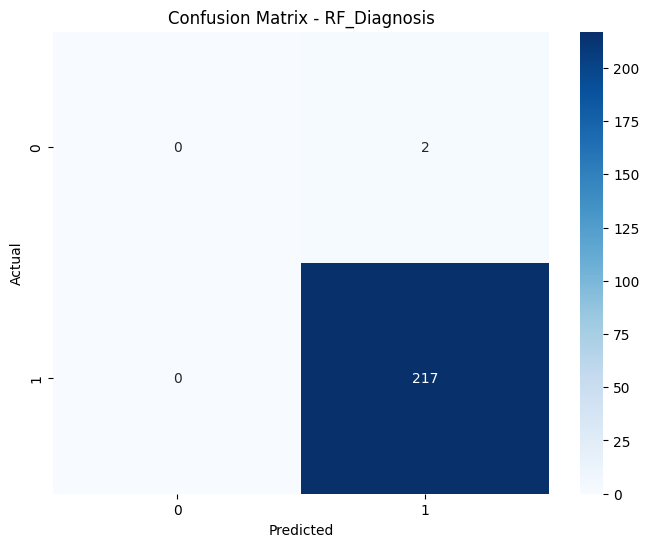


-------------------- RF_Stage Results --------------------
Accuracy: 0.5205
Sensitivity (Recall): 0.2000
Specificity: nan

Confusion Matrix:
 [[  0   2   0   0   0]
 [  0 114   0   0   0]
 [  0  62   0   0   0]
 [  0  35   0   0   0]
 [  0   6   0   0   0]]


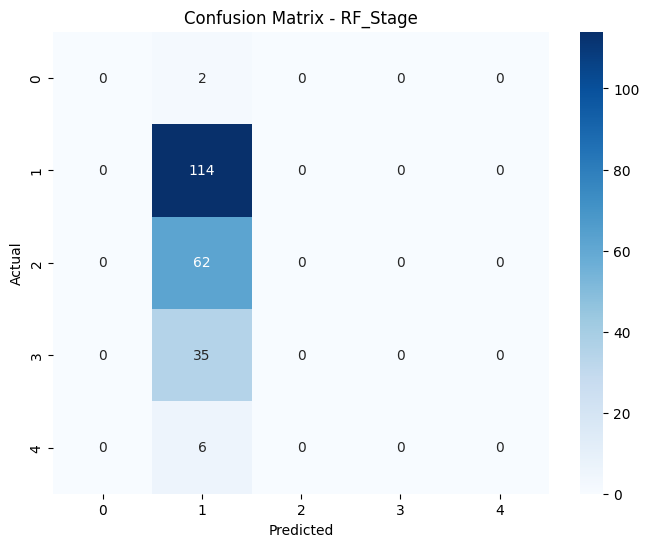


-------------------- RF_Subtype Results --------------------
Accuracy: 0.5571
Sensitivity (Recall): 0.3729
Specificity: nan

Confusion Matrix:
 [[ 0  1  1]
 [ 0 71 42]
 [ 0 53 51]]


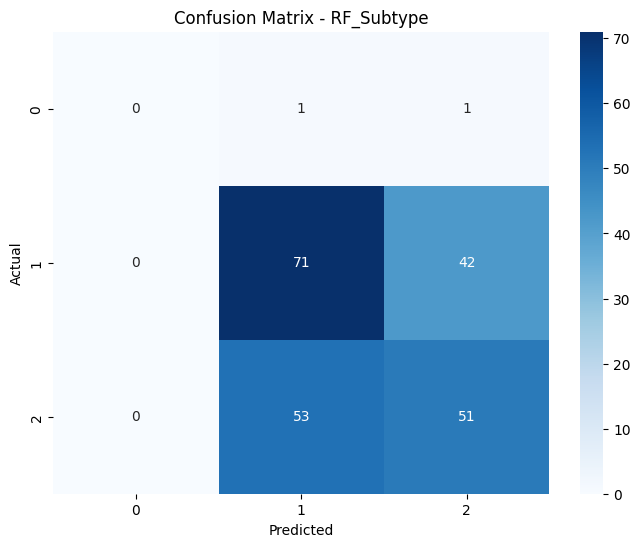

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to compute sensitivity, specificity, and confusion matrix
def evaluate_model(y_test, y_pred, model_name):
    """
    Evaluate model performance with accuracy, sensitivity, specificity, and confusion matrices.
    
    Args:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted labels.
        model_name (str): Name of the model being evaluated.

    Returns:
        dict: Contains accuracy, sensitivity, specificity, and confusion matrix.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute sensitivity (recall) & specificity
    if cm.shape == (2, 2):  # Binary classification case
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:  # Multiclass case
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=1))  # Macro-average recall
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=0))  # Macro-average specificity

    # Print evaluation results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm.tolist(),
    }

# Evaluate Diagnosis, Stage, and Subtype models
metrics_diagnosis.update(evaluate_model(y_diagnosis_test, metrics_diagnosis["best_model"].predict(X_test), "RF_Diagnosis"))
metrics_stage.update(evaluate_model(y_stage_test, metrics_stage["best_model"].predict(X_test), "RF_Stage"))
metrics_subtype.update(evaluate_model(y_subtype_test, metrics_subtype["best_model"].predict(X_test), "RF_Subtype"))

### Feature Importance, Correlation, and Covariance Matrices


Top 10 Important Features for RF_Diagnosis:
 ['hsa-mir-1270', 'hsa-mir-3116-1', 'hsa-mir-326', 'hsa-mir-365a', 'hsa-mir-675', 'hsa-mir-221', 'hsa-mir-627', 'hsa-mir-4662a', 'hsa-mir-514a-3', 'hsa-mir-151a']


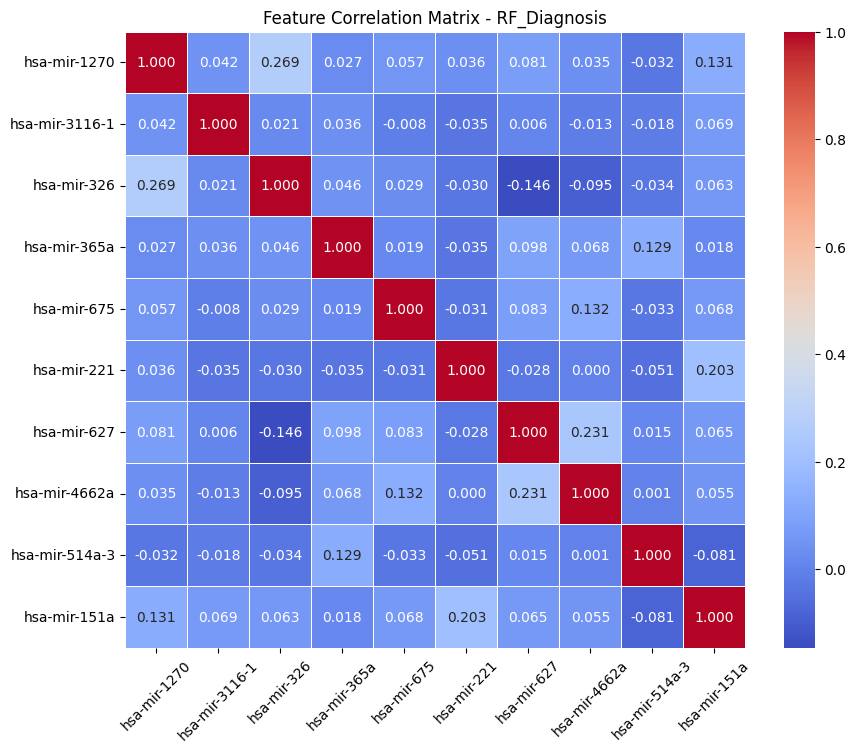

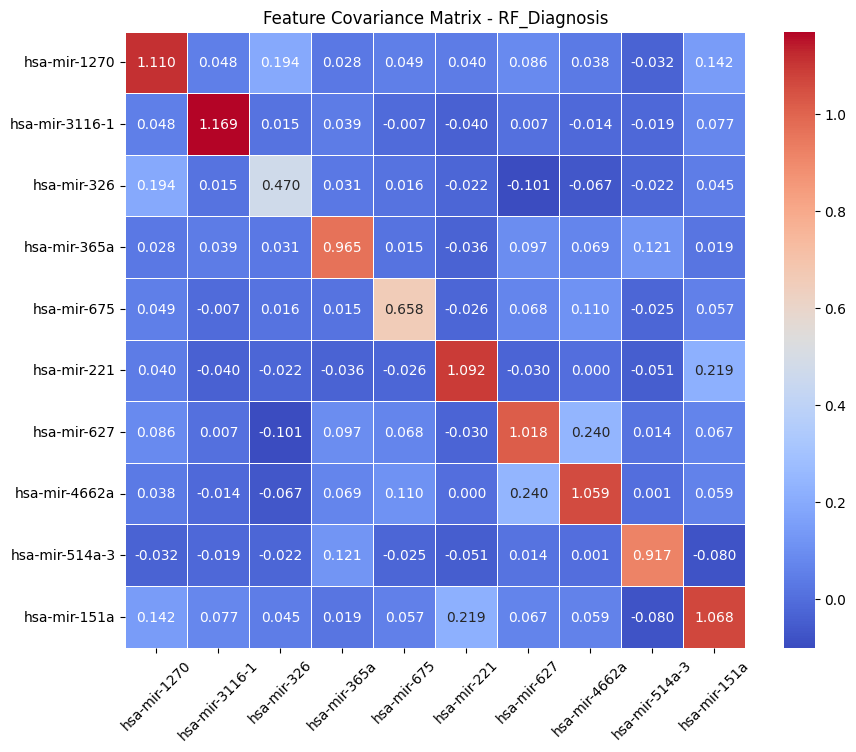


Top 10 Important Features for RF_Stage:
 ['hsa-mir-5684', 'hsa-mir-449b', 'hsa-mir-4461', 'hsa-mir-7706', 'hsa-mir-218-1', 'hsa-mir-598', 'hsa-mir-449a', 'hsa-mir-3130-1', 'hsa-mir-6509', 'hsa-mir-4762']


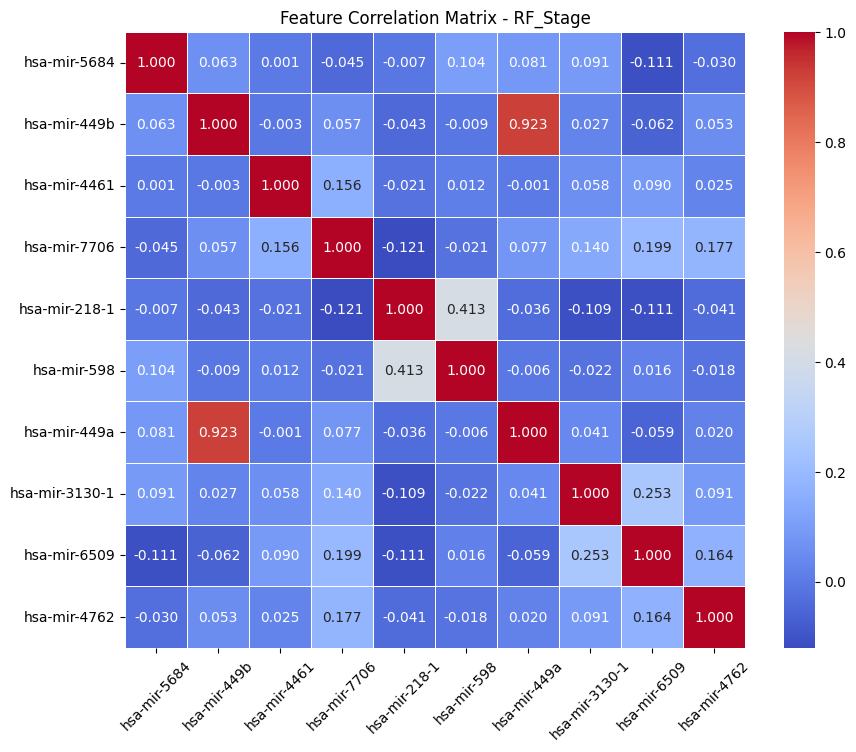

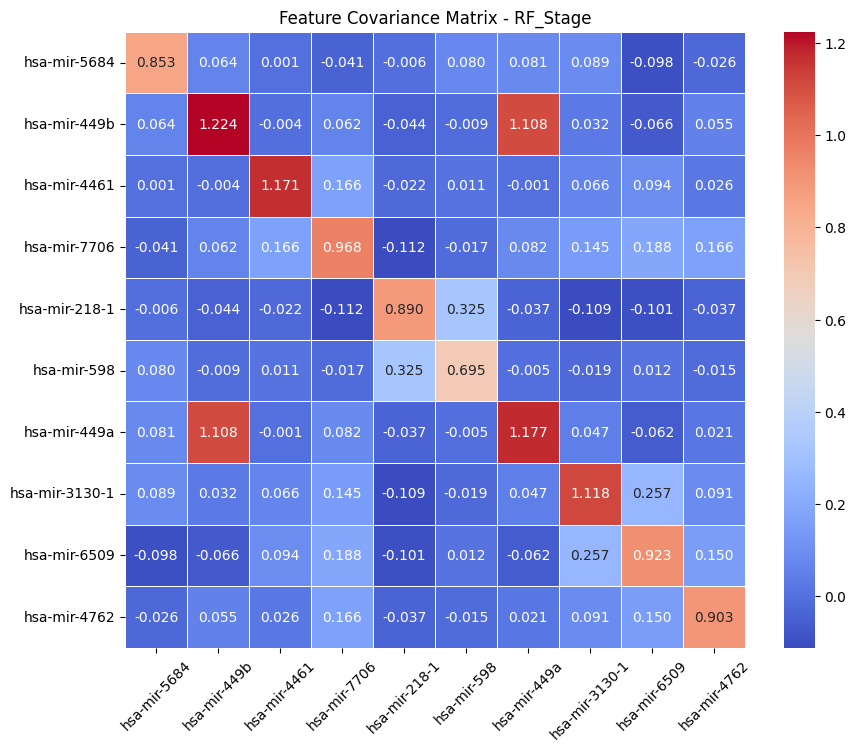


Top 10 Important Features for RF_Subtype:
 ['hsa-mir-4661', 'hsa-mir-135a-2', 'hsa-mir-23c', 'hsa-mir-6879', 'hsa-mir-202', 'hsa-mir-185', 'hsa-mir-26a-2', 'hsa-mir-4786', 'hsa-mir-30b', 'hsa-mir-29b-2']


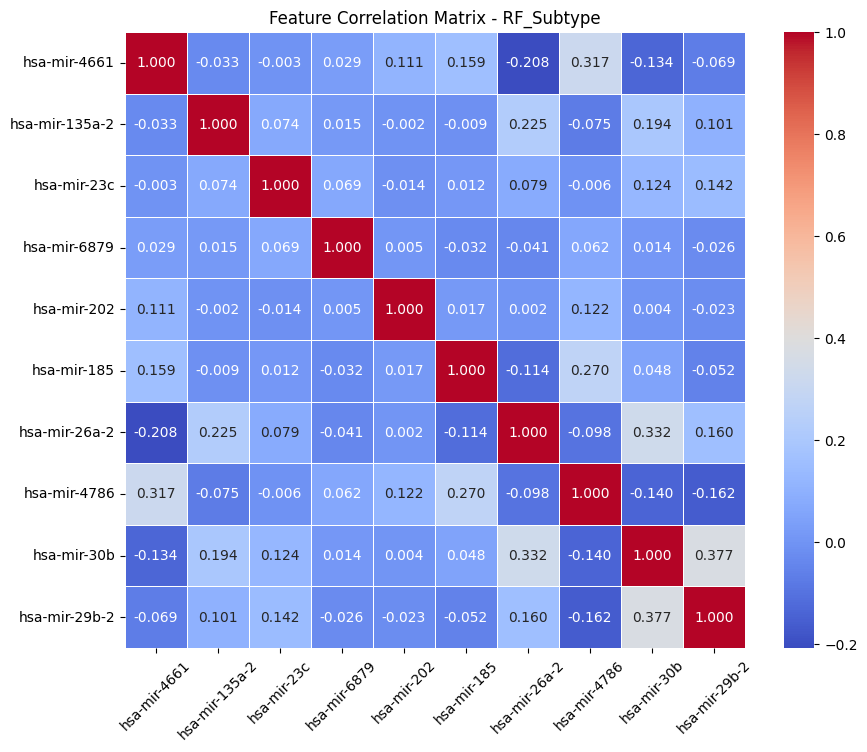

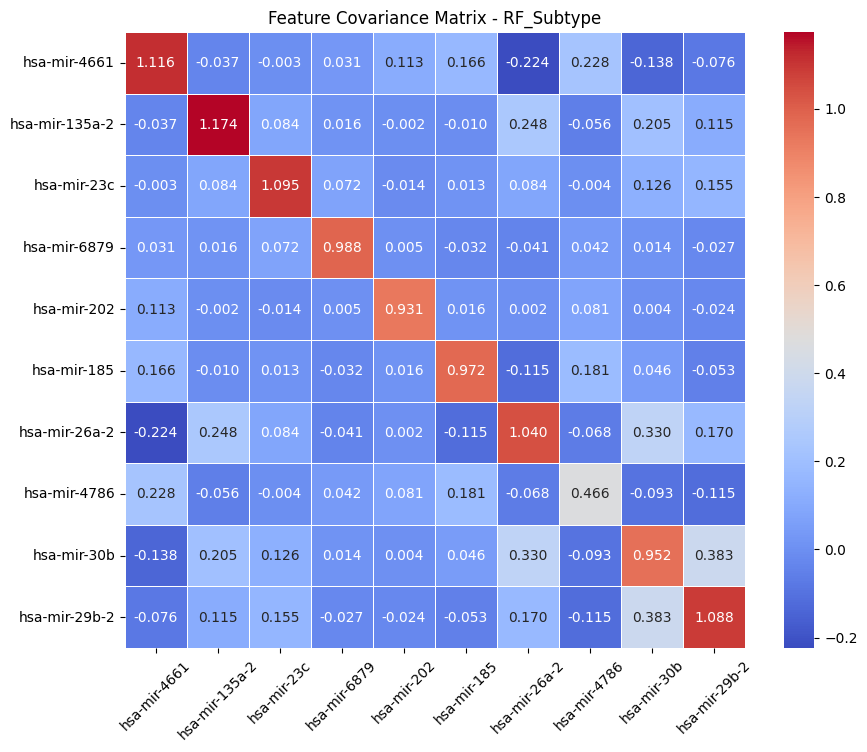

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute and plot correlation and covariance matrices
def feature_importance_analysis(model, X_train, model_name):
    """
    Extracts top 10 features from Random Forest, computes correlation and covariance matrices,
    and generates plots.

    Args:
        model (RandomForestClassifier): Trained RF model.
        X_train (DataFrame): Training feature set.
        model_name (str): Name of the classification task.

    Returns:
        dict: Dictionary containing top 10 features, correlation matrix, and covariance matrix.
    """
    # Extract feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    top_10_features = feature_importances.nlargest(10).index.tolist()

    print(f"\nTop 10 Important Features for {model_name}:\n", top_10_features)

    # Compute correlation matrix
    corr_matrix = X_train[top_10_features].corr()

    # Compute covariance matrix
    cov_matrix = X_train[top_10_features].cov()

    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
    plt.title(f"Feature Correlation Matrix - {model_name}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    # Plot covariance matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
    plt.title(f"Feature Covariance Matrix - {model_name}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    return {
        "top_10_features": top_10_features,
        "correlation_matrix": corr_matrix,
        "covariance_matrix": cov_matrix,
    }

# Perform feature analysis for Diagnosis, Stage, and Subtype
feature_analysis_diagnosis = feature_importance_analysis(metrics_diagnosis["best_model"], pd.DataFrame(X_train, columns=X.columns), "RF_Diagnosis")
feature_analysis_stage = feature_importance_analysis(metrics_stage["best_model"], pd.DataFrame(X_train, columns=X.columns), "RF_Stage")
feature_analysis_subtype = feature_importance_analysis(metrics_subtype["best_model"], pd.DataFrame(X_train, columns=X.columns), "RF_Subtype")

### Saving All Results & Models

In [17]:
import os
import json
import joblib

# Define output directory
output_dir = "../results/random_forest/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save trained models
joblib.dump(metrics_diagnosis["best_model"], os.path.join(output_dir, "rf_model_diagnosis.pkl"))
joblib.dump(metrics_stage["best_model"], os.path.join(output_dir, "rf_model_stage.pkl"))
joblib.dump(metrics_subtype["best_model"], os.path.join(output_dir, "rf_model_subtype.pkl"))

print("Random Forest models saved successfully.")

# Save predictions & actual labels
predictions = {
    "Diagnosis": (y_diagnosis_test, metrics_diagnosis["best_model"].predict(X_test), "rf_predictions_diagnosis.csv"),
    "Stage": (y_stage_test, metrics_stage["best_model"].predict(X_test), "rf_predictions_stage.csv"),
    "Subtype": (y_subtype_test, metrics_subtype["best_model"].predict(X_test), "rf_predictions_subtype.csv"),
}

for label, (y_test, y_pred, filename) in predictions.items():
    pred_path = os.path.join(output_dir, filename)
    pd.DataFrame({"actual": y_test, "predicted": y_pred}).to_csv(pred_path, index=False)
    print(f"{label} predictions saved to {pred_path}")

# Save metadata (hyperparameters, accuracy, sensitivity, specificity)
metadata = {
    "diagnosis_hyperparameters": metrics_diagnosis["classification_report"],
    "stage_hyperparameters": metrics_stage["classification_report"],
    "subtype_hyperparameters": metrics_subtype["classification_report"],
    "diagnosis_accuracy": metrics_diagnosis["accuracy"],
    "stage_accuracy": metrics_stage["accuracy"],
    "subtype_accuracy": metrics_subtype["accuracy"],
    "diagnosis_sensitivity": metrics_diagnosis["sensitivity"],
    "stage_sensitivity": metrics_stage["sensitivity"],
    "subtype_sensitivity": metrics_subtype["sensitivity"],
    "diagnosis_specificity": metrics_diagnosis["specificity"],
    "stage_specificity": metrics_stage["specificity"],
    "subtype_specificity": metrics_subtype["specificity"],
    "top_10_features_diagnosis": feature_analysis_diagnosis["top_10_features"],
    "top_10_features_stage": feature_analysis_stage["top_10_features"],
    "top_10_features_subtype": feature_analysis_subtype["top_10_features"],
}

metadata_path = os.path.join(output_dir, "rf_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to {metadata_path}")

# Save Correlation and Covariance Matrices
feature_analysis_diagnosis["correlation_matrix"].to_csv(os.path.join(output_dir, "rf_correlation_matrix_diagnosis.csv"))
feature_analysis_stage["correlation_matrix"].to_csv(os.path.join(output_dir, "rf_correlation_matrix_stage.csv"))
feature_analysis_subtype["correlation_matrix"].to_csv(os.path.join(output_dir, "rf_correlation_matrix_subtype.csv"))

feature_analysis_diagnosis["covariance_matrix"].to_csv(os.path.join(output_dir, "rf_covariance_matrix_diagnosis.csv"))
feature_analysis_stage["covariance_matrix"].to_csv(os.path.join(output_dir, "rf_covariance_matrix_stage.csv"))
feature_analysis_subtype["covariance_matrix"].to_csv(os.path.join(output_dir, "rf_covariance_matrix_subtype.csv"))

print("All matrices saved successfully.")

Random Forest models saved successfully.
Diagnosis predictions saved to ../results/random_forest/rf_predictions_diagnosis.csv
Stage predictions saved to ../results/random_forest/rf_predictions_stage.csv
Subtype predictions saved to ../results/random_forest/rf_predictions_subtype.csv
Metadata saved to ../results/random_forest/rf_metadata.json
All matrices saved successfully.
